In [1]:
#基本包导入
import numpy as np
import time
import tensorflow as tf

#调用显卡内存分配指令需要的包
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#关键功能导入
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

#实时数据增强功能 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#显卡内存分配指令：按需分配 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#z-score标准化转换 用来把训练和测试集的数据标准化的z-score方法  训练的快一些
def normalization(x_img_train, x_img_test):
    mean = np.mean(x_img_train, axis=(0, 1, 2, 3))#四个维度 批数 像素x像素 通道数
    std = np.std(x_img_train, axis=(0, 1, 2, 3))
    #测试集做一致的标准化 用到的均值和标准差 服从train的分布（有信息杂糅的可能）
    x_img_train = (x_img_train - mean) / (std + 1e-7)#trick 加小数点 避免出现整数 
    x_img_test = (x_img_test - mean) / (std + 1e-7) 
    #我觉得从统计学角度来讲，train test分布一致，所以可以这样做
    return x_img_train, x_img_test 

#数据读取
def load_images():
    (x_img_train, y_label_train), (x_img_test, y_label_test) = cifar10.load_data()

    x_img_train = x_img_train.astype(np.float32)#数据类型转换
    x_img_test = x_img_test.astype(np.float32)

    (x_img_train, x_img_test) = normalization(x_img_train, x_img_test)

    y_label_train = to_categorical(y_label_train, 10)#one-hot
    y_label_test = to_categorical(y_label_test, 10)
    
    return x_img_train, y_label_train, x_img_test, y_label_test

In [3]:
class ConvBNRelu(tf.keras.Model): 
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME', weight_decay=0.0005, rate=0.5, drop=True):
        
        #对继承自父类tf.keras.Model的属性进行初始化。而且是用tf.keras.Model的初始化方法来初始化继承的属性。TF要求这么写 后面放了链接
        super(ConvBNRelu, self).__init__() 
        self.drop = drop         
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                                        padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dropOut = keras.layers.Dropout(rate=rate)
        
        
#自定义函数api，必须用call方法 用于指定由层完成的计算。（无奈） 
#https://tensorflow.google.cn/guide/keras/functional#%E4%BD%BF%E7%94%A8%E8%87%AA%E5%AE%9A%E4%B9%89%E5%B1%82%E6%89%A9%E5%B1%95_api
    def call(self, inputs):#, training=False
        layer = self.conv(inputs) #第一个输入永远是inputs
        layer = tf.nn.relu(layer) #引用前面处理的layer有点像搭积木
        layer = self.batchnorm(layer)
        
        #用来控制conv是否有dropout层，对应类ConvBNRelu中的self.drop属性
        if self.drop:
            layer = self.dropOut(layer)

        return layer

In [4]:
#核心模型类 VGG16结构其实变得不是特别大
class VGG16Model(tf.keras.Model):
    def __init__(self):
        super(VGG16Model, self).__init__()
        self.conv1 = ConvBNRelu(filters=64, kernel_size=[3, 3], rate=0.3)
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], drop=False)
        self.maxPooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3])
        self.conv4 = ConvBNRelu(filters=128, kernel_size=[3, 3], drop=False)
        self.maxPooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv5 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv6 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv7 = ConvBNRelu(filters=256, kernel_size=[3, 3], drop=False)
        self.maxPooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv11 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv12 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv13 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv14 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv15 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv16 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling6 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flat = keras.layers.Flatten()
        self.dropOut = keras.layers.Dropout(rate=0.5)

        #正则化加在MLP中做，之前只在conv中做，此外只用一层隐藏层，因为之前过拟合(test_Accuracy-0.78)。
        self.dense1 = keras.layers.Dense(units=512,
                                         activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dense2 = keras.layers.Dense(units=100)
        self.softmax = keras.layers.Activation('softmax')

    def call(self, inputs):#, training=False
        net = self.conv1(inputs) #输入input，后面net接net一层层
        net = self.conv2(net)
        net = self.maxPooling1(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.maxPooling2(net)
        net = self.conv5(net)
        net = self.conv6(net)
        net = self.conv7(net)
        net = self.maxPooling3(net)
        net = self.conv11(net)
        net = self.conv12(net)
        net = self.conv13(net)
        net = self.maxPooling5(net)
        net = self.conv14(net)
        net = self.conv15(net)
        net = self.conv16(net)
        net = self.maxPooling6(net)
        net = self.dropOut(net)
        net = self.flat(net)
        net = self.dense1(net)
        net = self.batchnorm(net)
        net = self.dropOut(net)
        net = self.dense2(net)
        net = self.softmax(net)
        return net

In [9]:
#VGG13
class VGG13Model(tf.keras.Model):
    def __init__(self):
        super(VGG13Model, self).__init__()
        self.conv1 = ConvBNRelu(filters=64, kernel_size=[3, 3], rate=0.3)
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], drop=False)
        self.maxPooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3])
        self.conv4 = ConvBNRelu(filters=128, kernel_size=[3, 3], drop=False)
        self.maxPooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv5 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv6 = ConvBNRelu(filters=256, kernel_size=[3, 3])

        self.maxPooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv11 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv12 = ConvBNRelu(filters=512, kernel_size=[3, 3])

        self.maxPooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv14 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv15 = ConvBNRelu(filters=512, kernel_size=[3, 3])

        self.maxPooling6 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flat = keras.layers.Flatten()
        self.dropOut = keras.layers.Dropout(rate=0.5)

        #正则化加在MLP中做，之前只在conv中做，此外只用一层隐藏层，因为之前过拟合(test_Accuracy-0.78)。
        self.dense1 = keras.layers.Dense(units=512,
                                         activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dense2 = keras.layers.Dense(units=100)
        self.softmax = keras.layers.Activation('softmax')

    def call(self, inputs):#, training=False
        net = self.conv1(inputs) #输入input，后面net接net一层层
        net = self.conv2(net)
        net = self.maxPooling1(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.maxPooling2(net)
        net = self.conv5(net)
        net = self.conv6(net)
        #net = self.conv7(net)
        net = self.maxPooling3(net)
        net = self.conv11(net)
        net = self.conv12(net)
        #net = self.conv13(net)
        net = self.maxPooling5(net)
        net = self.conv14(net)
        net = self.conv15(net)
        #net = self.conv16(net)
        net = self.maxPooling6(net)
        net = self.dropOut(net)
        net = self.flat(net)
        net = self.dense1(net)
        net = self.batchnorm(net)
        net = self.dropOut(net)
        net = self.dense2(net)
        net = self.softmax(net)
        return net

In [11]:
#核心模型类 VGG19结构其实变得不是特别大
class VGG19Model(tf.keras.Model):
    def __init__(self):
        super(VGG19Model, self).__init__()
        self.conv1 = ConvBNRelu(filters=64, kernel_size=[3, 3], rate=0.3)
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], drop=False)
        self.maxPooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3])
        self.conv4 = ConvBNRelu(filters=128, kernel_size=[3, 3], drop=False)
        self.maxPooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv5 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv6 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv7 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv8 = ConvBNRelu(filters=256, kernel_size=[3, 3], drop=False)
        self.maxPooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv10 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv11 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv12 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv13 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv14 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv15 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv16 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv17 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling6 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flat = keras.layers.Flatten()
        self.dropOut = keras.layers.Dropout(rate=0.5)

        #正则化加在MLP中做，之前只在conv中做，此外只用一层隐藏层，因为之前过拟合(test_Accuracy-0.78)。
        self.dense1 = keras.layers.Dense(units=512,
                                         activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dense2 = keras.layers.Dense(units=100)
        self.softmax = keras.layers.Activation('softmax')

    def call(self, inputs):#, training=False
        net = self.conv1(inputs) #输入input，后面net接net一层层
        net = self.conv2(net)
        net = self.maxPooling1(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.maxPooling2(net)
        net = self.conv5(net)
        net = self.conv6(net)
        net = self.conv7(net)
        net = self.conv8(net)
        net = self.maxPooling3(net)
        net = self.conv10(net)
        net = self.conv11(net)
        net = self.conv12(net)
        net = self.conv13(net)
        net = self.maxPooling5(net)
        net = self.conv14(net)
        net = self.conv15(net)
        net = self.conv16(net)
        net = self.conv17(net)
        net = self.maxPooling6(net)
        net = self.dropOut(net)
        net = self.flat(net)
        net = self.dense1(net)
        net = self.batchnorm(net)
        net = self.dropOut(net)
        net = self.dense2(net)
        net = self.softmax(net)
        return net

In [6]:

    #两个版本接近点好 2.4.1 & 2.4.0
print('tf.__version__:',tf.__version__)
print('keras.__version__:',keras.__version__)


    #超参数
training_epochs = 2
batch_size = 96
learning_rate = 0.1
momentum = 0.9 #SGD加速动量
lr_decay = 1e-6 #学习衰减
lr_drop = 20 #衰减倍数

tf.random.set_seed(777)#可复现~

    

    

tf.__version__: 2.10.0
keras.__version__: 2.10.0


In [7]:
def lr_scheduler(epoch): #动态学习率衰减，epoch越大，lr衰减越剧烈。
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

x_img_train, y_label_train, x_img_test, y_label_test = load_images()
    # 实时数据增强 只做了随机水平翻转 和随机旋转。 
datagen = ImageDataGenerator(
        featurewise_center=False,  # 布尔值。将输入数据的均值设置为 0，逐特征进行。
        samplewise_center=False,  # 布尔值。将每个样本的均值设置为 0。
        featurewise_std_normalization=False,  # 布尔值。将输入除以数据标准差，逐特征进行。
        samplewise_std_normalization=False,  # 布尔值。将每个输入除以其标准差。
        zca_whitening=False,  # 布尔值。是否应用 ZCA 白化。
        #zca_epsilon  ZCA 白化的 epsilon 值，默认为 1e-6。
        rotation_range=15,  # 整数。随机旋转的度数范围 (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # 布尔值。随机水平翻转。
        vertical_flip=False)  # 布尔值。随机垂直翻转。

datagen.fit(x_img_train)

In [10]:
type(x_img_train)

numpy.ndarray

In [12]:
model = VGG19Model()#调用模型
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                        decay=1e-6, momentum=momentum, nesterov=True)
    #交换熵、自定义优化器，评价标准。
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.build(input_shape=[None,32,32,3])
model.summary()

Model: "vgg19_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu_36 (ConvBNRelu  multiple                 2048      
 )                                                               
                                                                 
 conv_bn_relu_37 (ConvBNRelu  multiple                 37184     
 )                                                               
                                                                 
 max_pooling2d_15 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv_bn_relu_38 (ConvBNRelu  multiple                 74368     
 )                                                               
                                                                 
 conv_bn_relu_39 (ConvBNRelu  multiple                 

In [8]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [9]:

    


    #validation_data=(x_img_test, y_label_test) 实时的用test测试，只是为了方便观察所以如此，不影响训练过程。

reset_keras()
t1=time.time()
model.fit(datagen.flow(x_img_train, y_label_train,
                                     batch_size=batch_size), epochs=training_epochs, verbose=2, callbacks=[reduce_lr],
                        steps_per_epoch=x_img_train.shape[0] // batch_size, validation_data=(x_img_test, y_label_test))   
t2=time.time()
CNNfit = float(t2-t1)
print("Time taken: {} seconds".format(CNNfit))

21
Epoch 1/2


: 

In [10]:
reset_keras()
scores = model.evaluate(x_img_test, 
                        y_label_test, verbose=0)
scores[1]

778


0.44609999656677246

In [13]:
scores

[2.4532501697540283, 0.44609999656677246]

In [12]:
reset_keras()
predictions = model.predict(x_img_test)
predictions_class = np.argmax(predictions, batch_size=batch_size，axis=1)

783


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

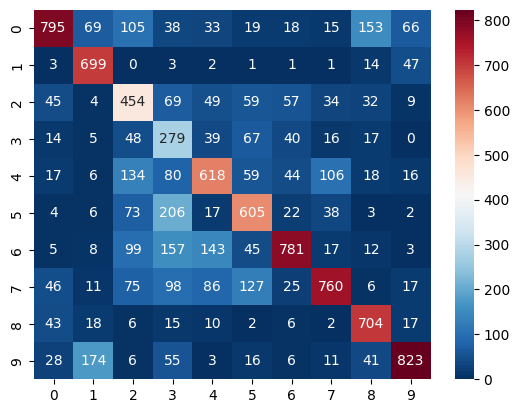

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
data = [np.argmax(one_hot)for one_hot in y_label_test]
cm = confusion_matrix(predictions_class,data)
heat_map = heatmap(cm,annot=True,fmt="d",cmap="RdBu_r")
heat_map.figure.savefig("result/16_epoch20_batch32.png")